# ToTs

This notebook contains helper functions for retrieving cluster ToT information. This is done by combining the ToT information for an event together with cluster positions for that same event. The result is then cached on disk for faster retrieval.

 * `get_cluster_tots(eta, phi)`: 
   Loads all cluster ToTs from the specified module (only the first layer, for now).
   Tries to load the ToTs from `data/cluster_tots/eta/phi.npy`. If it cannot find the file, 
   the ToTs are computed and then stored.
   
   **Returns: cluster_tots_by_event** : a dictionary with event IDs as keys and array of ToT matrices as values.
   Each matrix represents a single cluster.
   
   
 * `make_line_prediction(shape, y0, y1)`:
   Takes the parameters, which are the cluster shape (e.g. (2,20) for 2 x 20 cluster) and pair of coordinates
   which indicate the position of the brightest pixels on the left and right edges of the cluster.
 
   **Returns: prediction** : an matrix with the given shape containg a constant line connecting the edges at positions y0 and y1. If the line has a non-integer value at some point, the value is split between the top and bottom pixel.
   
See example further down.

In [3]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain
from itertools import groupby
import scipy.misc
import scipy.signal
from scipy import ndimage
import time
import os
import pickle
import cPickle
from matplotlib.colors import LogNorm
import sklearn.cluster

## Convert `cluster_sizes.ipynb` notebook to an ordinary python script, so that it can be imported here

!jupyter nbconvert --to script cluster_sizes.ipynb
import event_converter
import cluster_sizes
reload(event_converter)
reload(cluster_sizes)
from event_converter import *
from cluster_sizes import *

print 'Done.'

[NbConvertApp] Converting notebook cluster_sizes.ipynb to script
[NbConvertApp] Writing 15372 bytes to cluster_sizes.py
[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 7204 bytes to event_converter.py


<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 7204 bytes to event_converter.py


<IPython.core.display.Javascript object>

 Done.


In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
// this cell fixes the scroll boxes that are otherwise quite irritating

<IPython.core.display.Javascript object>

In [5]:
## Helper functions related to retrieving clusters

def cl_tots_path_and_filename(eta, phi):
    return ('data/cluster_tots/' + str(eta) + '/', str(phi) + '.dat')

def load_cluster_tots(eta, phi):
    path, filename = cl_tots_path_and_filename(eta, phi)
    
    cluster_tots = {}
    hits = get_hits(eta, phi)
    for eventID, positions in cl_positions.iteritems():
        cluster_tots_arr = []
        tot = get_tot_image(hits, eventID)
        for (x1, y1, x2, y2) in positions:
            cluster_tot = tot[x1:x2+1, y1:y2+1]
            ids = np.where(cluster_tot > 0)
            cluster_tots_arr.append(cluster_tot)
        cluster_tots[eventID] = cluster_tots_arr

    if not os.path.exists(path):
        os.makedirs(path)
    outfile = open(path + filename, 'wb')
    cPickle.dump(cluster_tots, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    outfile.close()
    return cluster_tots

def get_cluster_tots(eta, phi):
    path, filename = cl_tots_path_and_filename(eta, phi)
    if not os.path.exists(path + filename):
        return load_cluster_tots(eta, phi)
    else:
        infile = open(path + filename, 'r')
        data = cPickle.load(infile)
        infile.close
        return data 
    
def make_line_prediction(shape, y0, y1):
    num = shape[1]
    x, y = np.linspace(0, shape[1]-1, num), np.linspace(y0, y1, num)

    prediction = np.zeros(shape)
    for i in range(num):
        prediction[int(floor(y[i])), int(x[i])] = ceil(y[i]+0.00001) - y[i]
        prediction[int(ceil(y[i])), int(x[i])] = y[i] - floor(y[i]-0.00001)
    return prediction

## Example

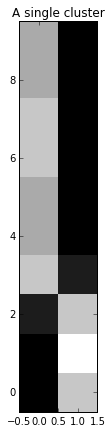

In [76]:
# Show the n-th cluster for the given event and module
def show_single_cluster(eta, phi, eventID, n):
    cluster_tots_by_event = get_cluster_tots(eta, phi)
    cluster_tots_for_event = cluster_tots_by_event[eventID]
    cluster_tot = cluster_tots_for_event[n]
    show_gray(cluster_tot, 'A single cluster', origin='lower')
    
#show_single_cluster(25, 10, 17, 3)

def show_line_prediction(shape, y0, y1):
    prediction = make_line_prediction(shape, y0, y1)
    show_gray(prediction, 'A line prediction', origin='lower')
    
#show_line_prediction((2, 8), 0, 1)

#eta = 25
#phi = 10
#eventID = 17
#n = 0

#cluster_tots_by_event = get_cluster_tots(eta, phi)
#cluster_tots_for_event = cluster_tots_by_event[eventID]
#cluster_tot = cluster_tots_for_event[n]
#plt.figure(figsize=(14, 7))
#plt.imshow(15-cluster_tot, cmap="gray", interpolation="nearest")
#plt.axis("off")
#plt.savefig('cluster_example.png')

#prediction = make_line_prediction(cluster_tot.shape, 0, 1)
#plt.figure(figsize=(14, 7))
#plt.imshow(1-prediction, cmap="gray", interpolation="nearest")
#plt.axis("off")
#plt.savefig('line_template_example.png')

#plt.figure(figsize=(14, 7))
#plt.imshow(1-np.abs(cluster_tot/15.0 - prediction), vmax=1.0, vmin=0, cmap="gray", interpolation="nearest")
#plt.axis("off")
#plt.savefig('line_template_deltas_example.png')


## Cluster size vs. cluster energy heatmap

eta: -30 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -29 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -28 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -27 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -26 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -25 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -24 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -23 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -22 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -21 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -11 phi

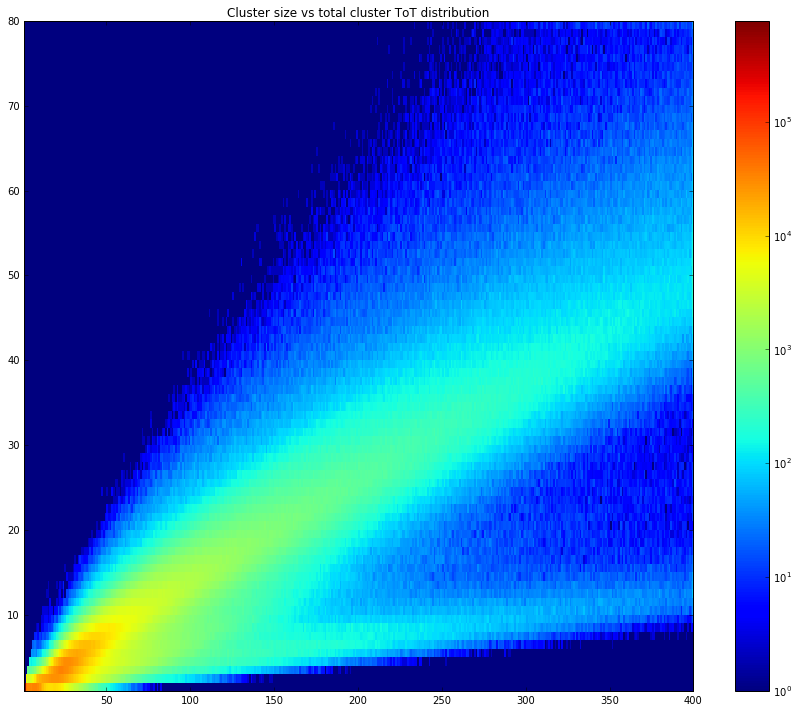

In [5]:
def cluster_size_vs_energy_heatmap():
    tot_size = []

    found_event = 0

    for eta_i in range(-30, 31):
        print 'eta:', eta_i, 'phi:', 
        for phi_i in range(0, 16):
            print phi_i,
            cl_positions = cluster_positions(eta_i, phi_i)
            cluster_tots = get_cluster_tots(eta_i, phi_i)
            for eventID, positions in cl_positions.iteritems():
                for (i, (x1, y1, x2, y2)) in enumerate(positions):
                    cluster_tot = cluster_tots[eventID][i]
                    total_tot = np.sum(cluster_tot)
                    num_hits = len(np.where(cluster_tot > 0)[0])
                    tot_size.append((num_hits, total_tot))
        print

    tot_size = np.array(tot_size)

    plt.figure(figsize=(15, 12))
    plt.title('Cluster size vs total cluster ToT distribution')
    H, yedges, xedges = np.histogram2d(tot_size[:, 0], tot_size[:, 1], bins=(range(1, 81), range(1, 401)))
    norm = LogNorm(1, H.max())
    plt.imshow(np.clip(H, 1, H.max()), norm=norm, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')
    plt.savefig('cluster_size_vs_tot.png')
    
# cluster_size_vs_energy_heatmap()

## Cluster length vs eta heatmap split by energies

eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 1

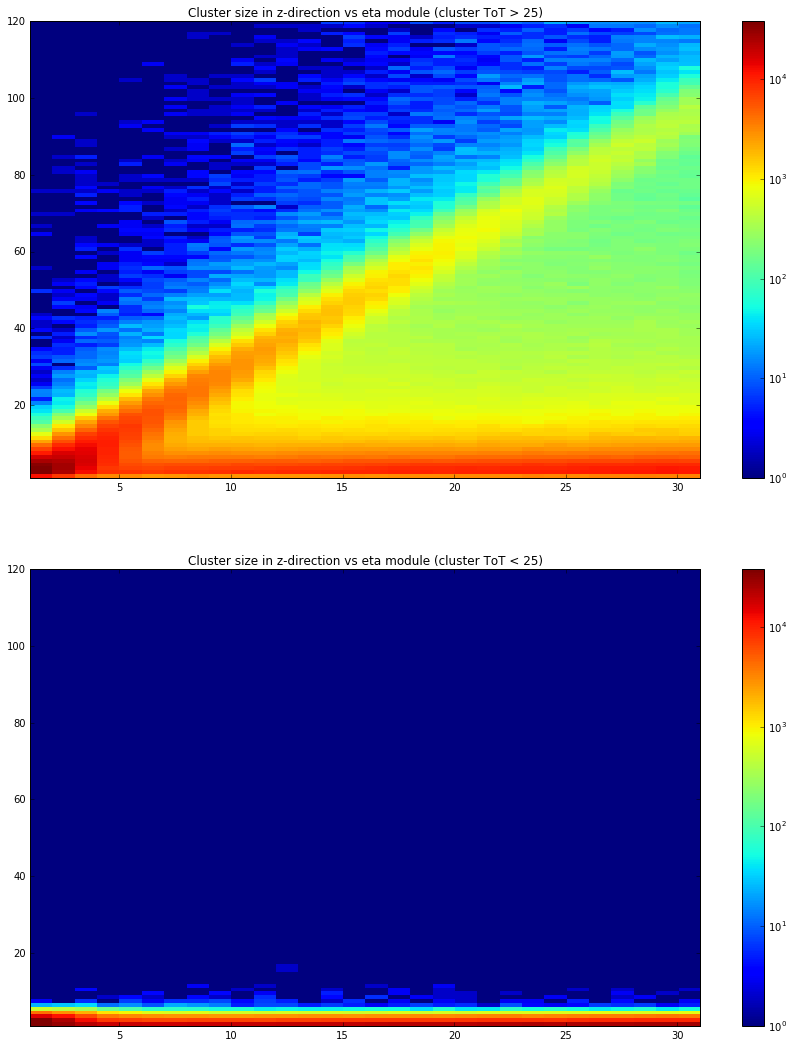

In [129]:
def cluster_sizes_for_eta_with_filter(eta, min=0, max=9e99):
    print 'eta:', eta, 'phi:',
    sizes = np.zeros((0,2))
    sizes2 = np.zeros((0,2))
    for phi_i in range(0, 16):
        print phi_i,
        cl_positions = cluster_positions(eta, phi_i)
        cluster_tots = get_cluster_tots(eta, phi_i)
        for eventID, positions in cl_positions.iteritems():
            tots = np.array([np.sum(cluster_tots[eventID][i]) for (i, _) in enumerate(positions)])
            sz = cluster_sizes(positions[np.where((tots > min) & (tots <= max))[0], :])
            sz2 = cluster_sizes(positions[np.where((tots <= min) | (tots > max))[0], :])
            sizes = np.vstack([sizes, sz])
            sizes2 = np.vstack([sizes2, sz2])
    print
    return (sizes, sizes2)

def show_length_heatmap_per_eta(eta1, eta2, filter):
    plt.figure(figsize=(15, 18))
    
    eta_lengths = []
    eta_lengths2 = []
    for eta_i in range(eta1, eta2+1):
        sizes, sizes2 = cluster_sizes_for_eta_with_filter(eta_i, min=filter)
        sizes[:, 0] = eta_i
        sizes2[:, 0] = eta_i
        eta_lengths.append(sizes)
        eta_lengths2.append(sizes2)

    eta_lengths = np.vstack(eta_lengths)
    eta_lengths2 = np.vstack(eta_lengths2)
    
    plt.subplot(2, 1, 1)
    plt.title('Cluster size in z-direction vs eta module (cluster ToT > ' + str(filter) + ')')
    H, yedges, xedges = np.histogram2d(eta_lengths[:, 1], eta_lengths[:, 0], bins=(range(1, 121), range(1, 32)))
    norm = LogNorm(1, H.max())
    plt.imshow(np.clip(H, 1, H.max()), norm=norm, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')

    plt.subplot(2, 1, 2)
    plt.title('Cluster size in z-direction vs eta module (cluster ToT < ' + str(filter) + ')')
    H, yedges, xedges = np.histogram2d(eta_lengths2[:, 1], eta_lengths2[:, 0], bins=(range(1, 121), range(1, 32)))
    norm = LogNorm(1, H.max())
    plt.imshow(np.clip(H, 1, H.max()), norm=norm, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')

    plt.savefig('cluster_length_eta_tot_split_' + str(filter) + '.png')

# show_length_heatmap_per_eta(1, 30, 25)

In [50]:
def find_tot_stats():
    maxes = []
    for eta_i in range(1, 31):
        print 'eta:', eta_i, 'phi:', 
        for phi_i in range(0, 16):
            print phi_i,
            hits = get_hits(eta_i, phi_i)
            events = list(np.unique(hits[2,:]))
            for eventID in events:
                tot = get_tot_image(hits, eventID)
                max_tot = np.max(tot)
                maxes.append(max_tot)
        print

    print np.mean(maxes), np.std(maxes), np.max(maxes)
    
# find_tot_stats()

eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 1

## Cluster shape clustering and classification in 2D

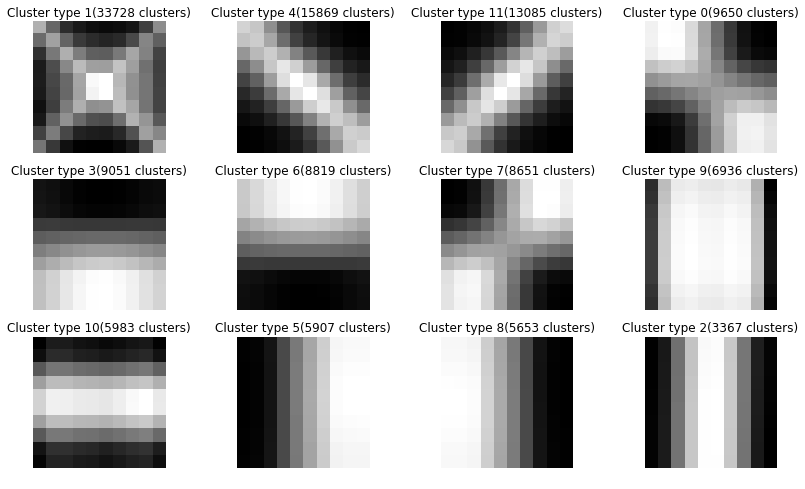

In [68]:
def cluster_cluster_shapes(eta):
    tots = []

    for phi_i in range(0, 16):
        print phi_i,
        cluster_tots = get_cluster_tots(eta, phi_i)

        total_tots = np.zeros((10,10))
        for eventID, clusters in cluster_tots.iteritems():
            for cluster_tot in clusters:
                tot_resized = scipy.misc.imresize(cluster_tot, (10, 10), interp='bilinear')
                tots.append(tot_resized)
    print

    tots_X = np.array(tots).reshape((len(tots), 100))

    N = 12

    kmeans = sklearn.cluster.KMeans(n_clusters=N, random_state=123).fit(tots_X)
    pred_y = kmeans.predict(tots_X)
    group_definitions = dict()

    plt.figure(figsize=(14,8))

    indexes = range(N)
    indexes.sort(key=lambda i:-len(np.where(pred_y == i)[0]))
    for (j,i) in enumerate(indexes):
        group = np.array(tots)[np.where(pred_y == i), :, :][0]
        title='Cluster type ' + str(i) + '(' + str(group.shape[0]) + ' clusters)'
        plt.subplot(N/4, 4, j+1)
        group_definitions[i] = np.sum(group, axis=0)
        plt.imshow(group_definitions[i], cmap="gray", interpolation="nearest")
        plt.axis("off")
        plt.title(title)

    plt.savefig('tot_eta_clustering_'+str(eta)+'.png')
    return kmeans

# kmeans = cluster_cluster_shapes(25)

(-25, 25)

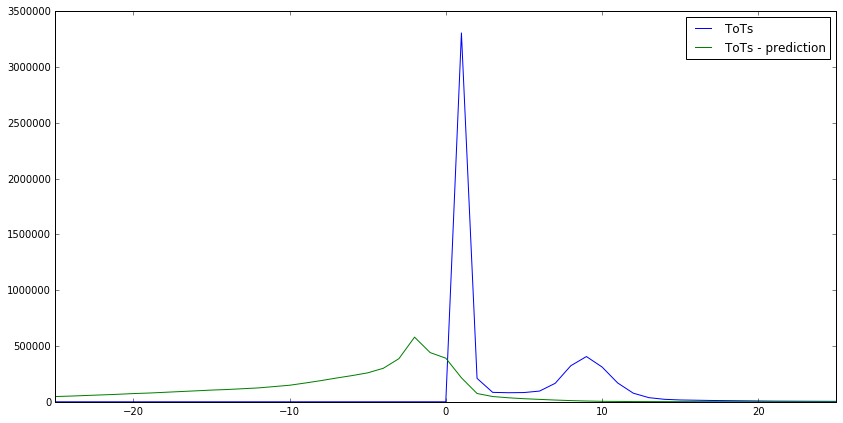

In [75]:
def plot_shape_prediction_histogram(eta, kmeans):
    n = 0

    bins = np.array(range(-128,128))
    tot_hist = np.zeros((255))
    pred_hist = np.zeros((255))

    for phi_i in range(0, 16):
        print phi_i,
        cluster_tots = get_cluster_tots(eta, phi_i)

        for eventID, clusters in cluster_tots.iteritems():
            for cluster_tot in clusters:
                cluster_square = scipy.misc.imresize(cluster_tot, (10, 10), interp='bilinear')
                definition = group_definitions[kmeans.predict(cluster_square.reshape((1, 100)))[0]]
                prediction = scipy.misc.imresize(definition, cluster_tot.shape, interp='bilinear')
                prediction = 1.0*prediction/np.max(prediction)*np.max(cluster_tot)

                hist, _ = np.histogram(cluster_tot, bins)
                tot_hist += hist
                hist, _ = np.histogram(cluster_tot - prediction, bins)
                pred_hist += hist

                n += 1

    print
    
    plt.figure(figsize=(14,7))

    bins = range(-127,128)
    plt.plot(bins, tot_hist, label='ToTs')
    plt.plot(bins, pred_hist, label='ToTs - prediction')
    plt.legend()
    plt.xlim([-25, 25])
    
# plot_shape_prediction_histogram(25, kmeans)

## Cluster shape clustering and classification in 1D

Fit a line through the cluster and collect samples along this line. Use this for clustering.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15


NameError: global name 'kmeans' is not defined

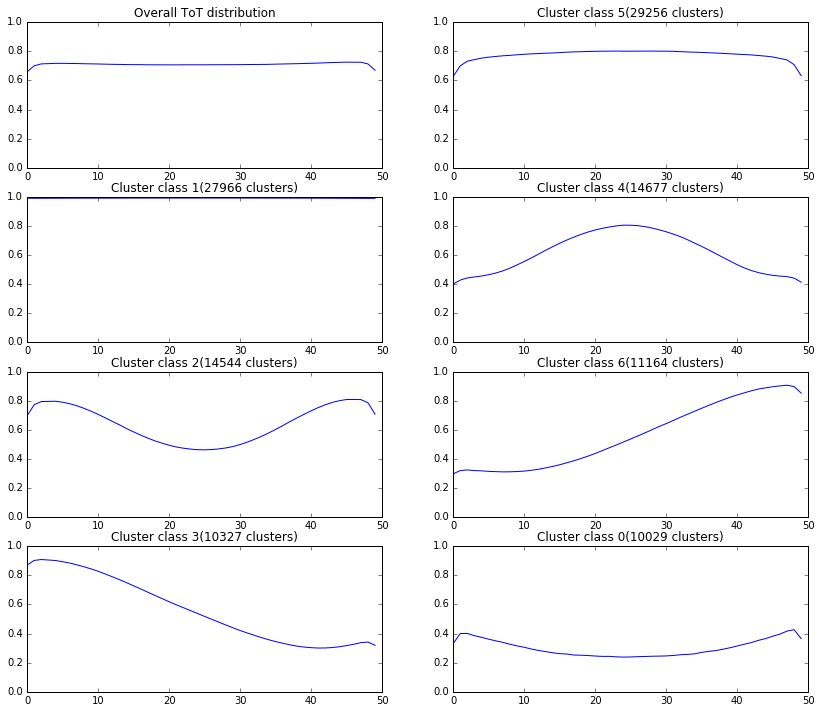

In [6]:
def cluster_cluster_line_profiles(eta):
    tot_lines = []

    for phi_i in range(0,16):
        print phi_i,
        for eventID, clusters in get_cluster_tots(eta, phi_i).iteritems():
            for cluster in clusters:
                left_max = np.argmax(cluster, axis=0)[0]
                right_max = np.argmax(cluster, axis=0)[-1]

                x0, y0 = 0, left_max
                x1, y1 = cluster.shape[1]-1, right_max

                num = 50
                x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
                zi = scipy.ndimage.map_coordinates(cluster, np.vstack((y,x)), order=3, mode='constant')
                zi = zi / np.max(zi)
                tot_lines.append(zi)
    print

    N = 7
    line_kmeans = sklearn.cluster.KMeans(n_clusters=N, random_state=234).fit(tot_lines)
    line_preds = line_kmeans.predict(tot_lines)
    group_line_definitions = {}

    plt.figure(figsize=(14,12))
    plt.subplot((N+1)/2, 2, 1)
    plt.plot(np.vstack(tot_lines).mean(axis=0))
    plt.title('Overall ToT distribution')
    plt.ylim([0, 1])

    indexes = range(N)
    indexes.sort(key=lambda i:-len(np.where(line_preds == i)[0]))
    for (j,i) in enumerate(indexes):
        group = np.array(tot_lines)[np.where(line_preds == i), :][0]
        title = 'Cluster class ' + str(i) + '(' + str(group.shape[0]) + ' clusters)'
        plt.subplot((N+1)/2, 2, j+2)
        group_line_definitions[i] = np.mean(group, axis=0)
        plt.plot(group_line_definitions[i])
        plt.ylim([0, 1])
        plt.title(title)

    plt.savefig('tot_eta_line_clustering_norm_'+str(eta)+'.png')
    return line_kmeans

#line_kmeans = cluster_cluster_line_profiles(15)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15


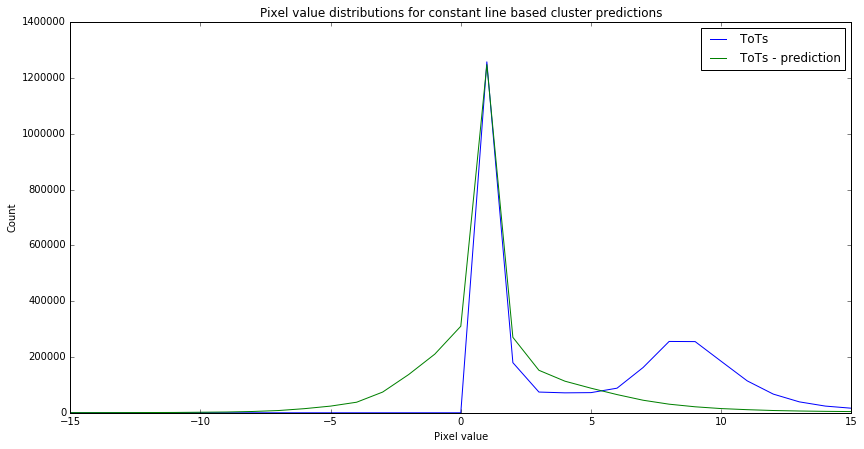

In [198]:
def plot_line_prediction_histogram(eta):
    bins = np.array(range(-128,128))
    tot_hist = np.zeros((255))
    pred_hist = np.zeros((255))

    for phi_i in range(0,16):
        print phi_i,
        for eventID, clusters in get_cluster_tots(eta, phi_i).iteritems():
            for cluster_tot in clusters:
                left_max = np.argmax(cluster_tot, axis=0)[0]
                right_max = np.argmax(cluster_tot, axis=0)[-1]
                y0 = left_max
                y1 = right_max
                num = cluster_tot.shape[1]
                x, y = np.linspace(0, cluster_tot.shape[1]-1, num), np.linspace(y0, y1, num)
                mean = cluster_tot[np.round([y,x]).astype(int).tolist()].mean()
                prediction = make_line_prediction(cluster_tot.shape, y0, y1) * mean

                hist, _ = np.histogram(cluster_tot, bins)
                tot_hist += hist
                hist, _ = np.histogram(cluster_tot - prediction, bins)
                pred_hist += hist            
    print

    plt.figure(figsize=(14,7))

    bins = range(-127,128)
    plt.plot(bins, tot_hist, label='ToTs')
    plt.plot(bins, pred_hist, label='ToTs - prediction')
    plt.legend()
    plt.xlim([-15, 15])
    plt.ylabel('Count')
    plt.xlabel('Pixel value')
    plt.title('Pixel value distributions for constant line based cluster predictions')
    plt.savefig('line_prediction_distribution_' + str(eta) + '.png')

# plot_line_prediction_histogram(5)